In [1]:
import sys
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()
%output size = 150
import scipy
from matplotlib import cm

bhz_parameters = {
    'topo': {'A': 0.5, 'B': 1.00, 'D': 0.0, 'M': 1.0,  'del_z': 0.0},
    'triv': {'A': 0.5, 'B': 1.00, 'D': 0.0, 'M': -1.0,  'del_z': 0.0},
    'topo2': {'A': 0.5, 'B': 1.00, 'D': 0.3, 'M': 1.0,  'del_z': 0.0},
    'slowed': {'A': 0.05, 'B': 0.08, 'D': 0.15, 'M': -0.3,  'del_z': 0.5}}

# Onsite and hoppings for bhz model

def onsite(site, p):
    return (p.M - 4 * p.B) * pauli.s0sz - 4 * p.D * pauli.s0s0 + p.del_z * pauli.sysy


def hopx(site1, site2, p):
    return p.B * pauli.s0sz + p.D * pauli.s0s0 + 1j * p.A * pauli.szsx


def hopy(site1, site2, p):
    return p.B * pauli.s0sz + p.D * pauli.s0s0 - 1j * p.A * pauli.s0sy


def bhz(w=20):
    """ Make ribbon system with bhz model. 

    slowed parameters are used on the edge for finite size system.
    """
    lat = kwant.lattice.square()

    def hopping_x(site1, site2, p):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return hopx(site1, site2, p) * np.exp(-0.5j * p.Bz * (x1 - x2) * (y1 + y2))

    slowed_par = SimpleNamespace(Bz=0, **bhz_parameters['slowed'])
    if w is None:
        sys = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs))
        sys[lat.shape(lambda pos: True, (0, 0))] = onsite
        sys[kwant.HoppingKind((1, 0), lat)] = hopping_x
        sys[kwant.HoppingKind((0, 1), lat)] = hopy
    else:
        sys = kwant.Builder(kwant.TranslationalSymmetry((1, 0)))
        sys[(lat(0, i) for i in range(w))] = onsite
        sys[kwant.HoppingKind((1, 0), lat)] = hopping_x
        sys[kwant.HoppingKind((0, 1), lat)] = hopy

        sys[lat(0, -1)] = lambda site, p: onsite(site, slowed_par)
        sys[lat(1, -1), lat(0, -1)] = lambda site1, site2, p: hopping_x(site1, site2, slowed_par)
        sys[lat(0, 0), lat(0, -1)] = hopy

        sys[lat(0, w)] = lambda site, p: onsite(site, slowed_par)
        sys[lat(1, w), lat(0, w)] = lambda site1, site2, p: hopping_x(site1, site2, slowed_par)
        sys[lat(0, w), lat(0, w - 1)] = hopy

    return sys


def bhz_cylinder(w=3):
    """ Make cylinder system with bhz model. """
    def ribbon_shape(pos):
        (x, y) = pos
        return (0 <= y < w)

    lat = kwant.lattice.square()
    sym = kwant.TranslationalSymmetry((1, 0))
    sys = kwant.Builder(sym)

    def hopping_x(site1, site2, p):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return hopx(site1, site2, p) * np.exp(-0.5j * p.Bz * (x1 - x2) * (y1 + y2))

    def hopy_phase(site1, site2, p):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return hopy(site1, site2, p) * np.exp(1j * p.ky)

    sys[lat.shape(ribbon_shape, (0, 0))] = onsite
    sys[kwant.HoppingKind((1, 0), lat)] = hopping_x
    sys[kwant.HoppingKind((0, 1), lat)] = hopy
    sys[kwant.HoppingKind((0, -w + 1), lat)] = hopy_phase

    sys[lat(0, 0)] = onsite
    sys[lat(0, w - 1)] = onsite

    return sys


def make_lead(t):
    def ribbon_shape(pos):
        (x, y) = pos
        return (0 <= y < 2)

    lat = kwant.lattice.square()
    sym = kwant.TranslationalSymmetry((1, 0))
    sys = kwant.Builder(sym)

    sys[lat.shape(ribbon_shape, (0, 0))] = 1.8 * t * pauli.s0sz
    sys[kwant.HoppingKind((1, 0), lat)] = -t * pauli.s0sz
    return sys


class TRIInfiniteSystem(kwant.builder.InfiniteSystem):

    def __init__(self, lead, trs):
        """A lead with time reversal invariant modes."""
        self.__dict__ = lead.__dict__
        self.trs = trs

    def modes(self, energy=0, args=()):
        prop_modes, stab_modes = \
            super(TRIInfiniteSystem, self).modes(energy=energy, args=args)
        n = stab_modes.nmodes
        stab_modes.vecs[:, n:(2 * n)] = self.trs(stab_modes.vecs[:, :n])
        stab_modes.vecslmbdainv[:, n:(2 * n)] = \
            self.trs(stab_modes.vecslmbdainv[:, :n])
        prop_modes.wave_functions[:, n:] = \
            self.trs(prop_modes.wave_functions[:, :n])
        return prop_modes, stab_modes


def trs(m):
    """Apply time reversal symmetry to a column vector or matrix m.

    The time reversal symmetry is given by the operator i * sigma_y * K, with K
    complex conjugation and sigma_y acting on the spin degree of freedom.

    Parameters:
    -----------
    m : NumPy array
        The vector or matrix to which TRS is applied.

    Returns:
    --------
    m_reversed : NumPy array
        The vector TRS * m as a NumPy array.

    Notes:
    ------
    Implementation inspired by kwant.rmt.
    """
    dim = m.shape[0]
    U = 1j * np.kron(np.identity(dim / 4), pauli.sys0)

    return U.T.conj().dot(m.conj())


def make_scatter_sys():
    def shape(pos):
        (x, y) = pos
        return (x == 0) * (0 <= y < 3)

    lat = kwant.lattice.square()
    sys = kwant.Builder()
    sys[lat.shape(shape, (0, 0))] = onsite
    sys[kwant.HoppingKind((0, 1), lat)] = hopy

    lead_cylinder = bhz_cylinder()
    lead = make_lead(1.0)
    sys.attach_lead(lead.reversed())
    sys.attach_lead(lead_cylinder)
    sys = sys.finalized()
    sys.leads[0] = TRIInfiniteSystem(sys.leads[0], trs)
    return sys


def scattering_det_pfaff(sys, p):

    def pfaffian(sys, p, ky):
        p.ky = ky
        smat = kwant.smatrix(sys, energy=0.0, args=[p]).data
        # since we get relatively large numerical errors we project the matrix on
        # the space of antisymmetric matrices
        smat = 0.5 * (smat - smat.T)
        return pf.pfaffian(smat)
    
    pfaff = [pfaffian(sys, p, 0), pfaffian(sys, p, np.pi)]
    
    ks = np.linspace(0.0, np.pi, 50)
    det = [np.linalg.det(kwant.smatrix(sys, energy=0.0, args=[p]).data) for p.ky in ks]
    det = np.array(det)

    phase = np.angle(pfaff[0]) + 0.5 * np.cumsum(np.angle(det[1:] / det[:-1]))
    kdims = ['$k_y$', 'phase']
    plot = holoviews.Path((ks[1:], phase), kdims=kdims)(style={'color': 'b'})
    plot *= holoviews.Points(([0, np.pi], np.angle(pfaff)), kdims=kdims)(style={'color': 'g'})
    xlims, ylims = slice(-0.2, np.pi + 0.2), slice(-np.pi - 0.2, np.pi + 0.2)
    pi_ticks = [(-np.pi, r'$-\pi$'), (0, '$0$'), (np.pi, r'$\pi$')]
    ticks = {'xticks': [(0, '0'), (np.pi, '$\pi$')], 'yticks': pi_ticks}
    return plot.relabel('Winding', depth=1)[xlims, ylims](plot=ticks)


def title(p):
    title = r'$A={:.2}$, $B={:.2}$, $D={:.2}$, $M={:.2}$'
    return title.format(p.A, p.B, p.D, p.M)


Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, interact, display_html, plt, pf, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex
from code/edx_components:
MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment
from code/functions:
spectrum, hamiltonian_array, h_k, pauli


Press this button to show/hide the code used in the notebook:


* [Introduction](#Introduction)
* [Adding symmetry to a topological insulator](#Adding-symmetry-to-a-topological-insulator)
* [A perfectly transmitted channel and Kramers degeneracy](#A-perfectly-transmitted-channel-and-Kramers-degeneracy)
* [Helical edge states are Kramers pairs](#Helical-edge-states-are-Kramers-pairs)
* [The quantum spin Hall effect](#The-quantum-spin-Hall-effect)
* [A model for the quantum spin Hall insulator](#A-model-for-the-quantum-spin-Hall-insulator)
* [Alternative point of view: fermion parity pump](#Alternative-point-of-view:-fermion-parity-pump)
* [Pumping expression for the topological invariant](#Pumping-expression-for-the-topological-invariant)
* [A simplification: inversion symmetry](#A-simplification:-inversion-symmetry)
* [Summary](#Summary)


# Introduction

Charles Kane from the University of Pennsylvania will introduce today's lecture on two dimensional topological insulators with time-reversal symmetry.

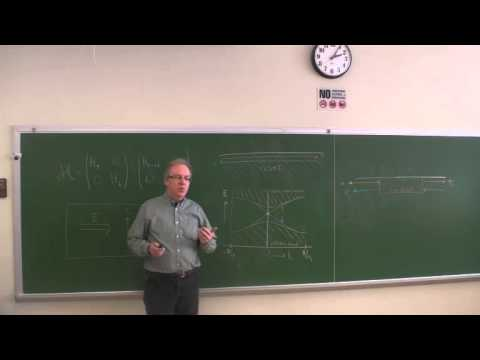

In [2]:
MoocVideo("n5oUQvvsYd0", src_location='5.1-intro', res='360')

# Adding symmetry to a topological insulator

In general, there are different approaches to discover new types of topological systems.

We have already used a very powerful method to make a Kitaev chain and the Chern insulator model. We started from guessing what kind of model to use for the edge, such that it is impossible to obtain without the bulk. Then we combined many such edges (dots for the Kitaev chain and wires for the Chern insulator) and tailored the coupling between them to leave exactly the type of model that we want on one edge.

A very skilled researcher in topology (or more specifically [K-theory](https://en.wikipedia.org/wiki/K-theory)) may also just calculate the expected topological classification of a system starting only from its dimensionality and symmetries. This is also a powerful method, but often it's too hard and requires a very high skills in math.

Another approach that we can undertake is to start with one topological Hamiltonian and see what happens if we force the Hamiltonian to have some extra symmetry. This is the approach we will use in this chapter.

Let's start from a simple example involving something which we already know, a quantum dot with the Hamiltonian $H_0$. We know that there is a topological invariant, the number of filled energy levels.

Now we can ask what happens if we force the dot to have a particle-hole symmetry. The Hamiltonian becomes

$$
H_\textrm{BdG} =
\begin{pmatrix}
H_0 & 0\\
0 & -H_0^*
\end{pmatrix}.
$$

This model is clearly topologically trivial from the point of view of the old invariant, since the number of filled states is constant. However, there are still level crossings that appear. We may ask if these crossings stay protected if we also include a finite superconducting pairing $\Delta$ in the Hamiltonian, which couples the two blocks $H_0$ and $-H_0^*$.

Of course we know the answer: the crossings stay protected due to the change in the Pfaffian invariant. So what we did was to construct a topologically non-trivial superconducting dot by adding particle-hole symmetry to a topological Hamiltonian with a lower symmetry.

Let's now apply the same logic to a new system. Specifically, let's add time-reversal symmetry to a Chern insulator. The Chern insulator has chiral edge states whose direction of propagation is flipped by time-reversal symmetry $\mathcal{T}$. So let's consider a Hamiltonian of the form

$$
H =
\begin{pmatrix}
H_0 & 0\\
0 & \mathcal{T}H_0\mathcal{T}^{-1}
\end{pmatrix}\,.
$$

If $H_0$ is the Hamiltonian of a Chern insulator with $N$ edge states, then $H$ will have $N$ pairs of counterpropagating edge states that transform into each other by time-reversal symmetry. Moreover, the full $H$ obeys time-reversal symmetry, which merely exchanges the two blocks.

The following sketch describes the situation in the case $N=1$:

![](figures/qsh_insulator.svg)

The next task which we now face is to understand if such edges stay topologically protected once we add coupling between the two blocks.

# A perfectly transmitted channel and Kramers degeneracy

We could try to see if all the edge states can be removed by adding some terms to the Hamiltonian, but instead we will use a closely related fact.

Let's study transport through such edge states as a function of their total number and let's only use the fact that time-reversal symmetry is present. Imagine, there is a total of $N$ states going in each direction along the edge, and that the edge is composed of a disordered region sandwiched between two clean regions. Again, let's represent the situation for the case $N=1$.

![](figures/qsh_scattering.svg)

## Scattering states

We label incoming states on the left and right with $\left|n,\textrm{L}\right\rangle$ and $\left|n,\textrm{R}\right\rangle$. The index $n$ goes from $1$ to $N$. The outgoing states are the time-reversed partners of the incoming states, so they are given by $\mathcal{T}\left|n,\textrm{L}\right\rangle$ and $\mathcal{T}\left|n,\textrm{R}\right\rangle$. Scattering states in the left and right regions are superpositions of incoming and outgoing states,

$$
\left|\Psi,\textrm{L}\right\rangle = \sum_{n=1}^N \alpha_{n,\textrm{L}}\,\left|n,\textrm{L}\right\rangle + \beta_{n,\textrm{L}}\,\mathcal{T}\left|n,\textrm{L}\right\rangle\,,
$$
$$
\left|\Psi,\textrm{R}\right\rangle = \sum_{n=1}^N \alpha_{n,\textrm{R}}\,\left|n,\textrm{R}\right\rangle + \beta_{n,\textrm{R}}\,\mathcal{T}\left|n,\textrm{R}\right\rangle\,.
$$

We can form vectors out of all the coefficients in the superposition, for instance $\alpha_\textrm{L} = (\alpha_{1,\textrm{L}},\dots,\alpha_{N,\textrm{L}})^T$ for the incoming states on the left side. Incoming and outgoing modes are then related by the scattering matrix $S$ of the disordered region,

$$
\begin{pmatrix} \beta_\textrm{L} \\ \beta_\textrm{R} \end{pmatrix} = S \begin{pmatrix} \alpha_\textrm{L} \\ \alpha_\textrm{R} \end{pmatrix}.
$$

There are a total of $2N$ incoming and $2N$ outgoing modes, so $S$ is a $2N\times 2N$ matrix. Since we are including all possible initial and final states, $S$ is also unitary, $S=S^\dagger$. It can be split into reflection and transmission blocks of dimension $N\times N$,

$$
S =
\begin{pmatrix}
r & t\\
t' & r'
\end{pmatrix}\,.
$$

If we can gap out the edges by adding some extra terms to the Hamiltonian, or backscatter them by adding disorder, then we should be able to achieve the situation where there is no transmission at all, $t = t' = 0$. In this case, all modes must be reflected back, so the reflection blocks of the scattering matrix become unitary, $r^\dagger r = r'^\dagger r' = 1$.

To see whether this is possible at all, we first have to understand the constraints that time-reversal symmetry imposes on $S$.

## Scattering matrices with time-reversal symmetry

Let's recall some basic facts about time-reversal symmetry, which we already studied in the first week. Time-reversal symmetry has an antiunitary operator $\mathcal{T}$ which commutes with the Hamiltonian. Being antiunitary, $\mathcal{T}$ may come in two flavors - either $\mathcal{T}^2=1$ or $\mathcal{T}^2=-1$. The first case applies to systems with no or integer spin, such that $\mathcal{T}=\mathcal{K}$ in the simplest case, where $\mathcal{K}$ is the complex conjugation operator. The second case applies to systems with half-integer spin, and in the simplest case we have $\mathcal{T}=i\sigma_y\mathcal{K}$.

Let's apply the time-reversal operator to our scattering states. We get

$$
\mathcal{T}\left|\Psi,\textrm{L}\right\rangle = \sum_{n=1}^N \alpha^*_{n,\textrm{L}}\,\mathcal{T}\left|n,\textrm{L}\right\rangle + \beta^*_{n,\textrm{L}}\,\mathcal{T}^2\left|n,\textrm{L}\right\rangle\,,
$$
$$
\mathcal{T}\left|\Psi,\textrm{R}\right\rangle = \sum_{n=1}^N \alpha^*_{n,\textrm{R}}\,\mathcal{T}\left|n,\textrm{R}\right\rangle + \beta^*_{n,\textrm{R}}\,\mathcal{T}^2\left|n,\textrm{R}\right\rangle\,.
$$

Now, since time-reversal symmetry does not change the energy of a state, $\mathcal{T}\left|\Psi,\textrm{R}\right\rangle$ and $\mathcal{T}\left|\Psi,\textrm{L}\right\rangle$ are scattering states with the same energy as $\left|\Psi,\textrm{R}\right\rangle$ and $\left|\Psi,\textrm{L}\right\rangle$. Hence, the coefficients of incoming and outgoing modes are still related by the same scattering matrix $S$ as before. Note, however, that applying $\mathcal{T}$ exchanged the role of the $\alpha$'s and $\beta$'s, such that the $\alpha$'s now correspond to outgoing states and the $\beta$'s to incoming states. Hence, we have

$$
 S\mathcal{T}^2 \begin{pmatrix}\beta^*_\textrm{L} \\ \beta^*_\textrm{R} \end{pmatrix} = \begin{pmatrix} \alpha^*_\textrm{L} \\ \alpha^*_\textrm{R} \end{pmatrix}\,.
$$

Multiplying both sides by $\mathcal{T}^2S^\dagger$ and taking the complex conjugate gives

$$
\begin{pmatrix} \beta_\textrm{L} \\ \beta_\textrm{R} \end{pmatrix} = \mathcal{T}^2\,S^T  \begin{pmatrix} \alpha_\textrm{L} \\ \alpha_\textrm{R} \end{pmatrix}.
$$

By comparing this equation with the one a few lines above, we finally obtain

$$
S = \mathcal{T}^2 S^T.
$$

So if $\mathcal{T}^2=1$, the scattering matrix is symmetric ($S=S^T$), while if $\mathcal{T}^2=-1$, it is antisymmetric ($S=-S^T$). 

What does this imply if we try to set $t=t'=0$?

If $S=S^T$, it turns out there is really nothing special we can tell. However, if $S=-S^T$ and $t=t'=0$, the $N\times N$ reflection matrix must be both unitary, $r^\dagger r=1$, and antisymmetric, $r=-r^T$.

If $N$ is odd, this isn't possible at all, since any odd-dimensional antisymmetric matrix [must have](https://en.wikipedia.org/wiki/Skew-symmetric_matrix#Spectral_theory) a single zero eigenvalue, while unitary matrices only have eigenvalues with unit norm!

We are forced to conclude that it is impossible to have $r$ unitary, and therefore it is impossible to have $t=0$ in this case. Furthermore, this zero eigenvalue of $r$ means that there is always a single mode that is transmitted with unit probability.

This is the discovery that Charles Kane described in the introductory video. We can quickly check it by randomly selecting an antisymmetric scattering matrix with odd $N$, like the following one with $N=3$,

In [3]:
N = 3
np.random.seed(12)
S = kwant.rmt.circular(N*2, sym='AII')

pprint_matrix(S)

/home/ton/Bot/current_work/topocm/code/init_mooc_nb.py:72: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  pretty_fmt_complex(num.imag) + 'i')


and looking at the eigenvalues of $r^\dagger r$ and $t^\dagger t$:

In [4]:
r = S[:N, :N]
print('Reflection eigenvalues')
pprint_matrix(np.linalg.eigvalsh(r.dot(r.T.conj())))

t = S[:N, N:]
print('Transmission eigenvalues')
pprint_matrix(np.linalg.eigvalsh(t.dot(t.T.conj()))[::-1])

Reflection eigenvalues


Transmission eigenvalues


> We conclude that if $\mathcal{T}^2=-1$ and the number of edge states going in one direction is odd, they cannot be gapped out, and the system is topological. On the other hand, if there is an even number of such edge states, they can be gapped out. Since these are the only two options, the integer invariant of a Chern insulator is reduced to a $\pm 1$ invariant in the presence of time reversal symmetry. These topologically protected, counterpropagating edge states are often referred to as **helical edge states**. 

# Helical edge states are Kramers pairs

You might ask yourself what makes $\mathcal{T}^2=-1$ special, leading to the topological protection of the helical edge states.

As was mentioned in the first week, if $\mathcal{T}^2=-1$ then Kramers' theorem applies. Kramers' theorem tells us that given an eigenstate $|\Psi\rangle$ of the Hamiltonian with energy $E$, its time-reversed partner $|\Psi_\mathcal{T}\rangle\equiv\mathcal{T}|\Psi\rangle$ has the same energy, and the two states are orthogonal, $\langle \Psi | \Psi_\mathcal{T}\rangle=0$. These two states form a so-called **Kramers pair**. As we already know, this leads to the fact that Hamiltonians with spinful time-reversal symmetry have two-fold degenerate energy levels - **Kramers degeneracy**.

Now, the two counterpropagating helical modes are time-reversed partners of each other, so they form precisely such a Kramers pair. The condition $\langle \Psi | \Psi_\mathcal{T}\rangle=0$ implies that it is impossible to introduce any backscattering between the two states, unless we break time-reversal symmetry. This is the origin of the unit transmission and of the topological protection of helical edge states.

To gain a more intuitive understanding of this fact at a more microscopic level, we can assume that the projection of the electrons' spin along a given axis is conserved, say the axis $z$ perpendicular to the plane. Then at the edge you have, say, a right-moving mode with spin up and a left-moving mode with spin down, and no other modes if $N=1$. Let's draw again the picture of a helical edge state entering the disordered region:

![](figures/spin_flip.svg)

Thus, an electron moving to the right must have spin up by assumption. In order to be reflected, its spin must also be flipped.  However, this spin-flip scattering process is forbidden, and again we conclude that the electron is transmitted with probability one.

In the case $\mathcal{T}^2=1$, there is no Kramers' theorem. As a consequence, even though you can construct models which have counterpropagating edge states, you will find that they have no topological protection and can be gapped out without breaking the time-reversal symmetry.

# The quantum spin Hall effect

There is no really precise name for the 2D topological insulator with time-reversal symmetry. It is often called "$\mathbb{Z}_2$ topological insulator." However, this simply indicates that there are only two values of the topological invariant, and so it isn't a very specific name.

The most commonly used name for this system is "quantum spin Hall insulator." To understand why, let's analyse a Hall bar made of such a non-trivial insulator. We will only need a Hall bar with four terminals, as shown below:

![](figures/qsh_hallbar.svg)

We have a finite voltage applied to terminal 1, so electrons are injected into the system from there. You can see that because of the helical edge states, there are as many modes connecting terminal 1 to terminal 3 as there are to terminal 4. A moment of thought, or otherwise a quick calculation, should convince you that in this case there is no net current flowing orthogonal to the applied voltage. The Hall conductance is zero, which is the expected result if time-reversal symmetry is preserved, as it is in our system.

However, counterpropagating edge states have to have exactly opposite spin due to Kramers degeneracy. This means that there may be a net spin current across the sample, orthogonal to the applied voltage.

In particular, let's again make the simple assumption that the spin projection along some axis is conserved. Then, in the figure above, all modes colored in red have spin up, and all modes colored in blue have spin down. So terminal 1 distributes electrons coming out of it according to their spin: all electrons with spin up end up in terminal 4, and all those with spin down in terminal 3. The system has a quantized spin current between terminals 3 and 4, hence the name "quantum spin Hall effect".

However, the quantized spin Hall current is not a general property of a quantum spin Hall insulator. Here, it arises because we have combined time reversal symmetry with a spin conservation law, and as we learned in the first week, conservation laws are boring from a topological point of view.

In [5]:
question = ("Consider the simple case where spin is conserved. "
            "In the quantum spin Hall bar system above, what happens if, instead of applying a voltage between terminals 1 and 2, "
            "you manage to apply a *spin-polarized* current between terminals 1 and 2?")

answers = ["The system will develop an opposite spin-polarized current to compensate the effect.",
           "A spin-polarized current will develop between terminals 3 and 4.",
           "A voltage difference will develop between terminals 3 and 4.",
           "It is impossible to apply such a current unless the bulk gap closes."]

explanation = ("The spin-polarized current will create an electron population imbalance between terminals 3 and 4. "
               "Hence, similar to the Hall effect, a voltage will develop orthogonal to the current.")

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=2, explanation=explanation)

MoocMultipleChoiceAssessment(**{'correct_answer': 2, 'explanation': 'The spin-polarized current will create an electron population imbalance between terminals 3 and 4. Hence, similar to the Hall effect, a voltage will develop orthogonal to the current.', 'max_attempts': 2, 'question': 'Consider the simple case where spin is conserved. In the quantum spin Hall bar system above, what happens if, instead of applying a voltage between terminals 1 and 2, you manage to apply a *spin-polarized* current between terminals 1 and 2?', 'answers': ['The system will develop an opposite spin-polarized current to compensate the effect.', 'A spin-polarized current will develop between terminals 3 and 4.', 'A voltage difference will develop between terminals 3 and 4.', 'It is impossible to apply such a current unless the bulk gap closes.'], 'display_name': 'Question'})

# A model for the quantum spin Hall insulator

There is an important model which can be used to describe quantum spin Hall insulators, known as the **Bernevig-Hughes-Zhang model** or, in short, BHZ model. In essence, this model is equivalent to two copies of the Chern insulator Hamiltonian on the square lattice that we studied in the fourth week.

The BHZ Hamiltonian takes the form

$$
H_\textrm{BHZ}(\mathbf{k}) = \begin{pmatrix} h(\mathbf{k}) & 0 \\ 0 & h^*(-\mathbf{k}) \end{pmatrix}\,,
$$

with

$$
h(\mathbf{k}) = \epsilon(\mathbf{k}) + \mathbf{d}(\mathbf{k})\cdot \pmb{\sigma}\,.
$$

Here $\pmb\sigma = (\sigma_x, \sigma_y, \sigma_z)$ is a vector of Pauli matrices acting on the electron/hole degree of freedom (the original two bands of the Chern insulator), $\epsilon(\mathbf{k}) = C - D(k_x^2+k_y^2)$, the vector $\mathbf{d} = [A k_x, -A k_y, M(\mathbf{k})]$, and
$M(\mathbf{k}) = M - B(k_x^2+k_y^2)$.

You can see that it is basically two copies of the massive Dirac Hamiltonian we used to study Chern insulators. In particular, there is a linear coupling in momentum between the holes and the electrons. The gap in the Hamiltonian is given by the term $M(\mathbf{k})$, a momentum-dependent effective mass.

By changing the sign of $M$ from negative to positive, you get a gap closing at $\mathbf{k}=\pmb{0}$:

b':HoloMap   [$M$]\n   :Overlay\n      .Surface.I   :Surface   [$k_x$,$k_y$]   ($E$)\n      .Surface.II  :Surface   [$k_x$,$k_y$]   ($E$)\n      .Surface.III :Surface   [$k_x$,$k_y$]   ($E$)\n      .Surface.IV  :Surface   [$k_x$,$k_y$]   ($E$)'
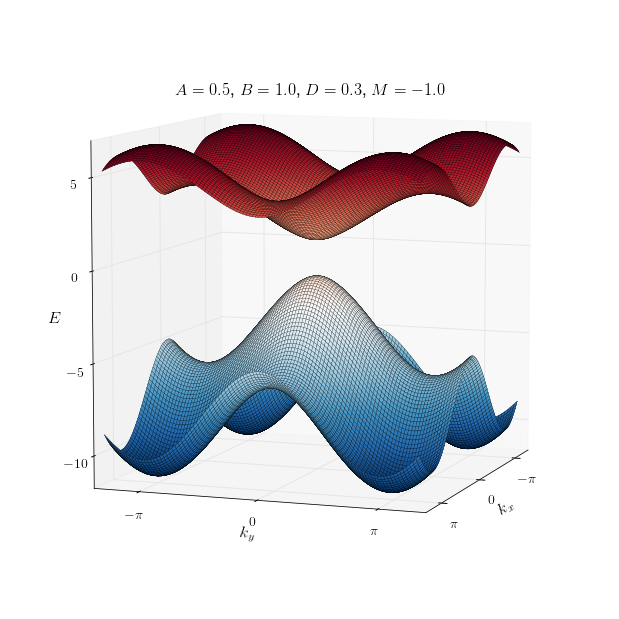
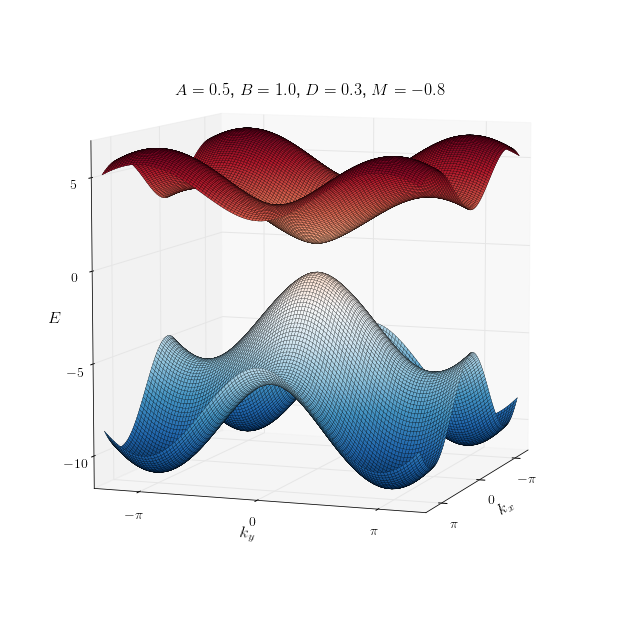
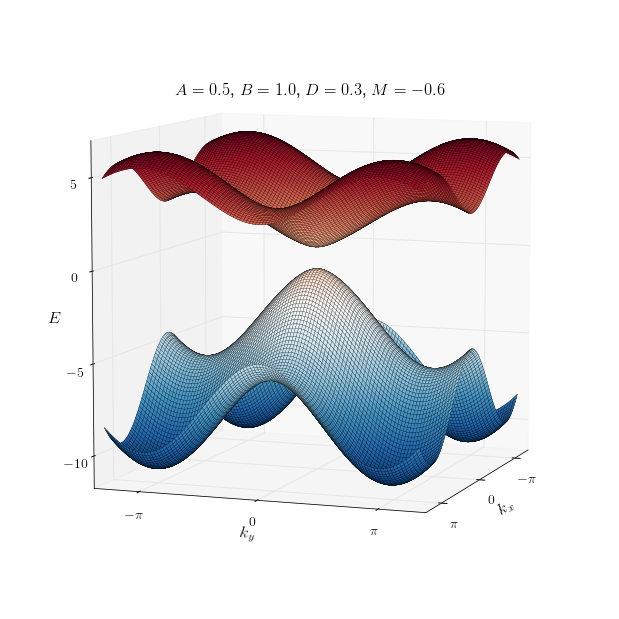
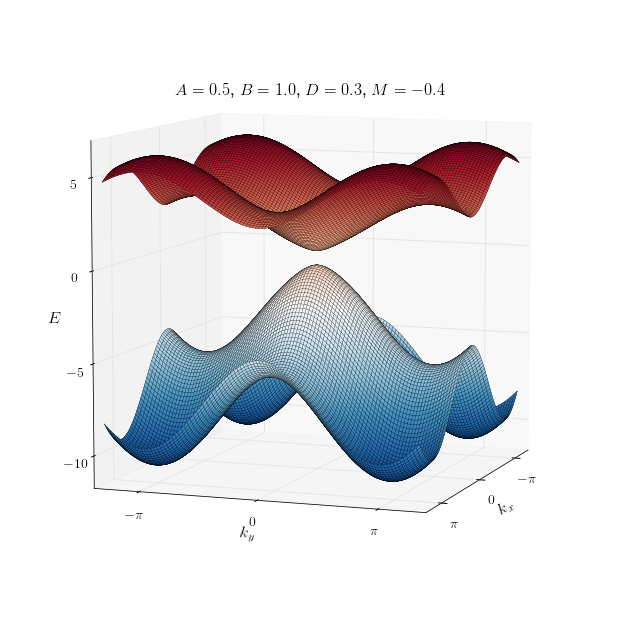
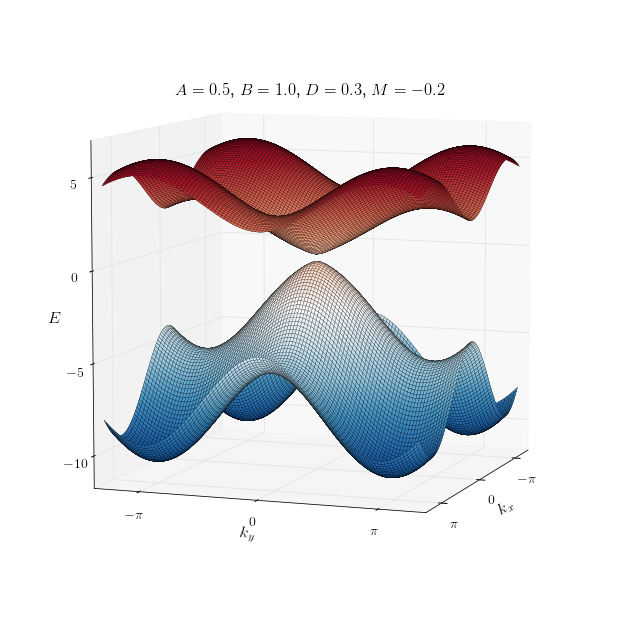
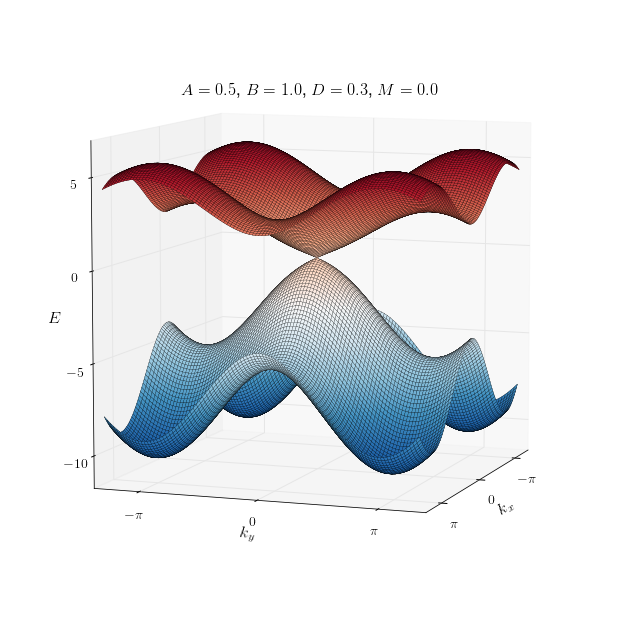
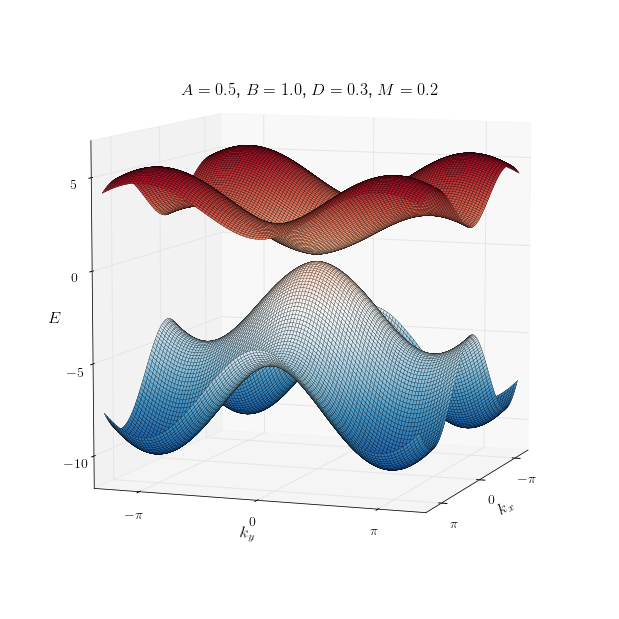
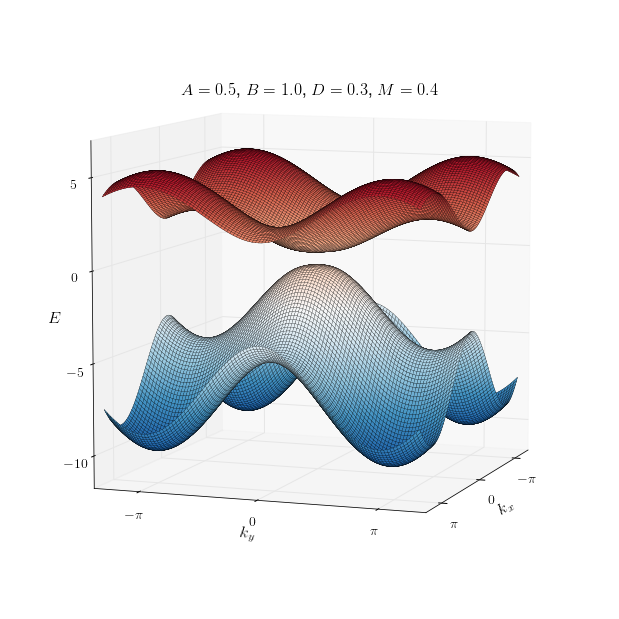
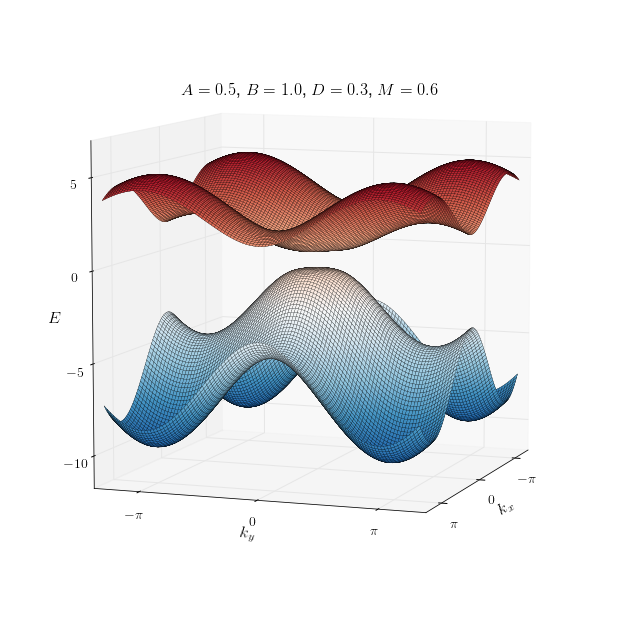
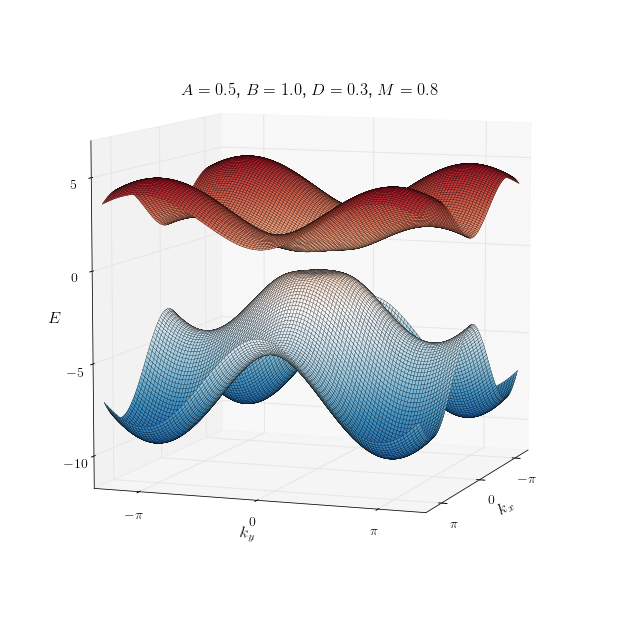
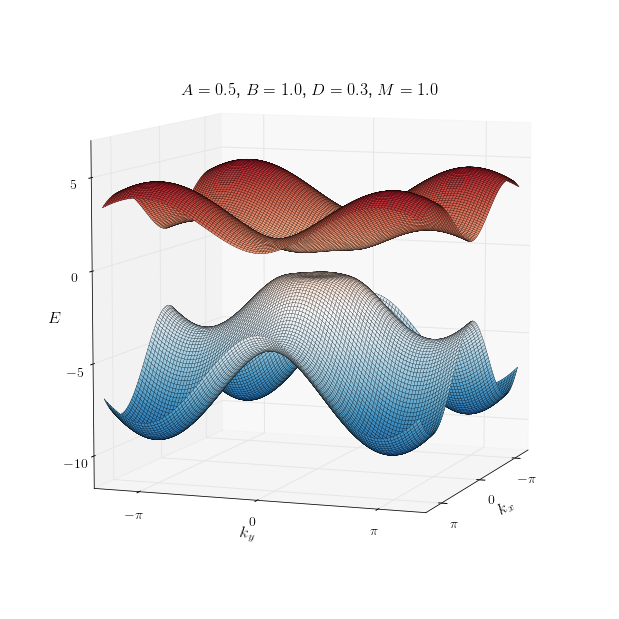

In [6]:
p = SimpleNamespace(Bz=0.0, **bhz_parameters['topo2'])
sys = bhz(w=None)
k = (4 / 3) * np.linspace(-np.pi, np.pi, 101)
kwargs = {'k_x': k, 'k_y': k, 'title': title}
Ms = np.linspace(-1, 1, 11)
holoviews.HoloMap({p.M: spectrum(sys, p, **kwargs) for p.M in Ms}, kdims=[r'$M$'])

This gap closing turns your trivial insulator into a topologically non-trivial quantum spin Hall insulator.

In the rest of this lecture, we will use the BHZ model as a toy-model to illustrate the behavior of a quantum spin Hall insulator using numerical examples. The BHZ model, however, is more than a toy-model, and it can be used to capture the behavior of some real semiconducting materials. For this reason, the BHZ model will be a main protagonist in the next chapter, where we will discuss real materials and the experimental evidence for the quantum spin Hall effect.

# Alternative point of view: fermion parity pump

In the previous cases of the Kitaev chain and the quantum Hall effect, the bulk topological invariant that we eventually obtained was characterized by the response to some adiabatic experiment.

Since the time-reversal invariant topological insulator is two dimensional like a quantum Hall system, it is reasonable to put the system in a Corbino geometry and change the flux through the system, creating an azimuthal electric field:

![](figures/qsh_corbino.svg)

However, because of time-reversal symmetry, the system is forbidden from having a Hall conductance and therefore there cannot be any charge transfer between the two edges of the disk. For instance, if we consider two copies of the Haldane model with opposite spin, there will be two quantum Hall pumps working in opposite directions (one transferring charge from the inner edge to the outer edge, the other one from the outer edge to the inner one). So the net charge transferred is zero.

Because the two pumps act on electrons with opposite spin, you might be tempted to define a spin current, which would flow in response to the electric field, orthogonal to it. However, as we just discussed, the spin along a given direction may not be conserved, so generally this is not a good way to define a robust pumping effect.

To understand what exactly happens in the pumping process, let's look at the energy spectrum of the edge states for the BHZ model in the cylinder geometry. As we discussed in the quantum Hall lectures, the cylinder geometry is really equivalent to the Corbino disk, except that it is easier to study.

You also learned that in a cylinder of finite circumference $L$, the momenta of the allowed edge states are quantized at values determined by the flux.

To make things more simple, you may actually imagine that the circumference of the cylinder is just a single unit cell long. We then have only one allowed value of the momentum $k$ along the edge, which is exactly proportional to the flux threaded through the cylinder, $k = 2\pi \Phi/\Phi_0$.

So let's look at the energy spectrum of a cylinder as a function of $k$ (or equivalently $\Phi$), and compare a cylinder in the quantum spin Hall phase with a cylinder in the trivial insulating phase.

:Layout
   .Overlay.Topological :Overlay
      .Path.Topological :Path   [$k$,$E$]
      .HLine.I          :HLine   [x,y]
   .Overlay.Trivial     :Overlay
      .Path.Trivial :Path   [$k$,$E$]
      .HLine.I      :HLine   [x,y]
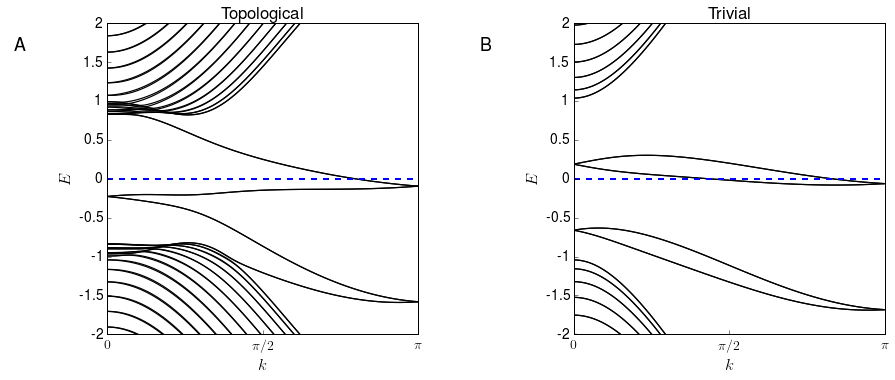

In [7]:
half_pi_ticks = [(0, '$0$'), (np.pi/2, r'$\pi/2$'), (np.pi, r'$\pi$')]
style = {'k_x': np.linspace(0, np.pi, 101),
         'xdim': r'$k$',
         'ydim': r'$E$',
         'xticks': half_pi_ticks,
         'yticks': np.linspace(-2, 2, 9),
         'xlims': [0, np.pi],
         'ylims': [-2, 2],
         'title': title}

sys = bhz(20)
p1 = SimpleNamespace(Bz=0, **bhz_parameters['topo'])
p2 = SimpleNamespace(Bz=0, **bhz_parameters['triv'])

(spectrum(sys, p1, **style).relabel('Topological') * holoviews.HLine(0) +
 spectrum(sys, p2, **style).relabel('Trivial') * holoviews.HLine(0))

In both cases you see that at $k=0$ there are isolated pairs of states with degenerate energies, between the valence and conduction bands. The Fermi energy is set at $E=0$, in the middle of the gap between conduction and valence bands. These states are the Kramers pairs at the edges - one pair for the topological case, two for the trivial case.
You also see the splitting of Kramers pairs as soon as $k$ goes away from zero. This is because $k = 0$ is a time-reversal invariant point, a point in momentum space that is mapped to itself by time-reversal symmetry.

The plot ends at $k=\pi$ (that is, $\Phi=h/2e$), which is another time-reversal invariant point. Indeed, time-reversal symmetry sends $\Phi\to-\Phi$, but for $\Phi=h/2e$ this corresponds exactly to adding or subtracting a flux quantum. Hence, all the physical properties of the system remain unchanged under the action of time-reversal for this value of the flux. And indeed you can see that all levels meet again and form Kramers pairs.

> We now see an interesting difference though. In the topological case, the Kramers pairs at $k=\pi$ are not the same as those at $k=0$. In the trivial case however, the pairs are the same. As a consequence, in the topological case there is an odd number of levels crossing zero-energy, while in the trivial cases there is an even number of them. Therefore changing the flux by $h/2e$ in the topological case changes the fermion parity at the edge, while it does nothing in the trivial case. We have thus obtained a **fermion parity pump**.

Strangely, this reminds us of the topological superconducting ring that we studied in the second week of the course. There we also had a fermion parity change in response to a flux. It turns out that this is not a coincidence, as we will see when we discuss how to realize topological superconductors using topological insulators.

You may appreciate that our argument did not rely on spin being a good quantum number, or on any other detail of the system, but only on Kramers theorem. And in fact it holds very generally. Deforming the dispersion of Kramers pairs does not break the fermion parity pump, as long as the way states combine to form Kramers pairs at $k=0$ and $k=\pi$ is unchanged.

# Pumping expression for the topological invariant

At this point, following the same path we followed for Chern insulator, we would like to find an expression for a topological bulk invariant which characterizes the quantum spin Hall effect.

However, we now encounter a problem: for complicated topological systems in higher dimensions, it is hard to evaluate the topological invariant. We know when the system is topological, and we know which values the topological invariant can take (for now just two: trivial and non-trivial), but it becomes hard to find and evaluate the correct expression for it.

We were able to calculate the Chern number using Berry curvature. The analogous computation for the topological invariant of the quantum spin Hall insulator is too involved, and so we will not present it in our course.

The scattering formulation of the topological invariant, however, is easy to implement and utilize. We can apply it by taking the cylinder threaded by a flux and connecting it to leads in the following geometry:

![](figures/qsh_pumping.svg)

Let us now study what happens when we try to inject electrons into the edges of the cylinder. Since we have “rolled-up” our system along one direction, we have a one-dimensional scattering problem. Similar to a Thouless pump, we expect to be able to find a topological signature in the reflection matrix $r$ for an electron coming in from the left.

As we vary the flux, the reflection properties may change, leading to a $k$-dependent reflection matrix $r(k)$. We assume that the bulk is gapped, so transmission is suppressed, and therefore $r$ is unitary. Moreover, at $k=0$ and $k=\pi$, $r$ is also antisymmetric because of time-reversal symmetry.

It turns out that the topological invariant has a relatively simple form:

$$
Q = \frac{\textrm{Pf}[r(0)]}{\textrm{Pf}[r(\pi)]}\sqrt{\frac{\det[r(\pi)]}{\det[r(0)]}}
$$

This expression relies on the antisymmetry of $r$ at $k=0$ and $k=\pi$. At these values we can compute the Pfaffian. The eigenvalues of $r$ come in pairs of opposite sign $e^{i\alpha}$, $-e^{i\alpha}$, which correspond to the Kramers pairs formed by the helical edge states. This means we can calculate the Pfaffian at these momentum values, but its phase is arbitrary.

We can however compute $\sqrt{\det[r(k)]}$ for all the intermediate values of $k$. To get rid of the sign ambiguity of the square root, we require that $\sqrt{\det[r(k)]}$ is continuous for all $k$, and that $\sqrt{\det[r(0)]} = \textrm{Pf}[r(0)]$. This only gives a unique answer if $\det r \neq 0$ for all $k$.

This gives us a curve which starts at $\textrm{Pf}[r(0)]$ and ends at either $\textrm{Pf}[r(\pi)]$ or $-\textrm{Pf}[r(\pi)]$. These two cases distinguish the trivial and nontrivial systems.

In the plot below, we show how this trajectory changes for our cylinder geometry as the BHZ model is driven through the topological phase transition. In the right panel, the green dots give you the phase of $\textrm{Pf}[r(0)]$ and $\textrm{Pf}[r(\pi)]$, and the blue line the phase of $\det[r(k)]$.

/usr/lib/python3/dist-packages/numpy/lib/twodim_base.py:233: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  m = zeros((N, M), dtype=dtype)
/usr/lib/python3/dist-packages/numpy/lib/twodim_base.py:240: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  m[:M-k].flat[i::M+1] = 1


:Layout
   .HoloMap.A_equals_0_full_stop_5_comma_B_equals_1_full_stop_0_comma_D_equals_0_full_stop_3_comma_M_equals_hyphen_minus_1_full_stop_0 :HoloMap   [$M$]
      :Overlay
         .Surface.I   :Surface   [$k_x$,$k_y$]   ($E$)
         .Surface.II  :Surface   [$k_x$,$k_y$]   ($E$)
         .Surface.III :Surface   [$k_x$,$k_y$]   ($E$)
         .Surface.IV  :Surface   [$k_x$,$k_y$]   ($E$)
   .HoloMap.Winding                                                                                                                    :HoloMap   [$M$]
      :Overlay
         .Path.I   :Path   [$k_y$,phase]
         .Points.I :Points   [$k_y$,phase]
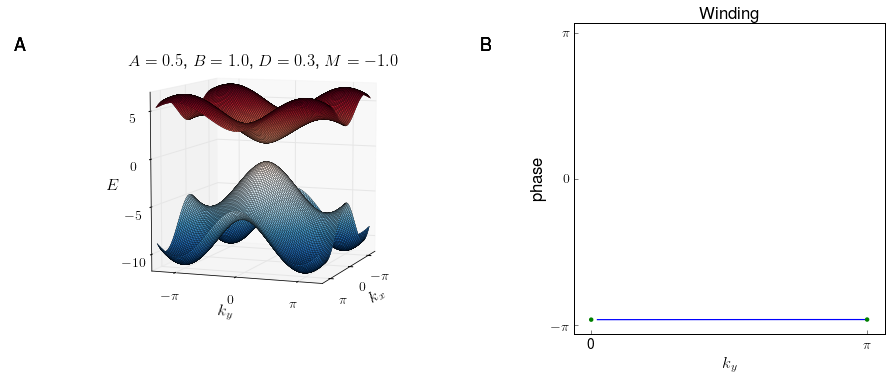
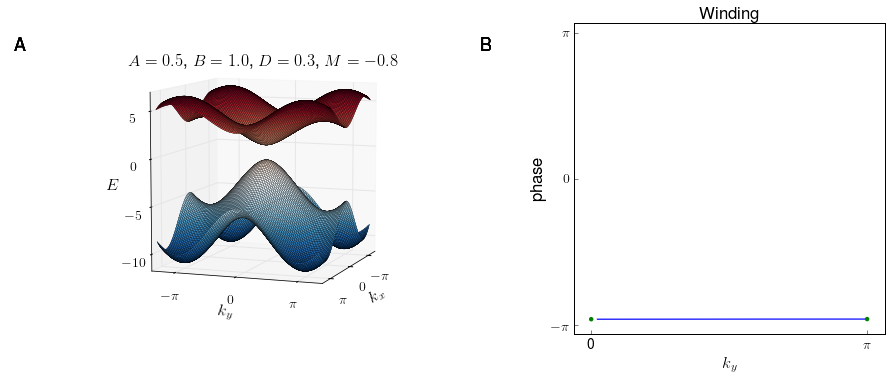
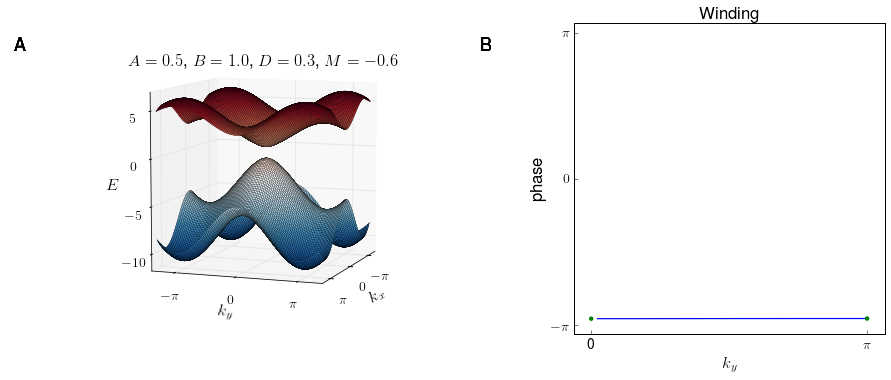
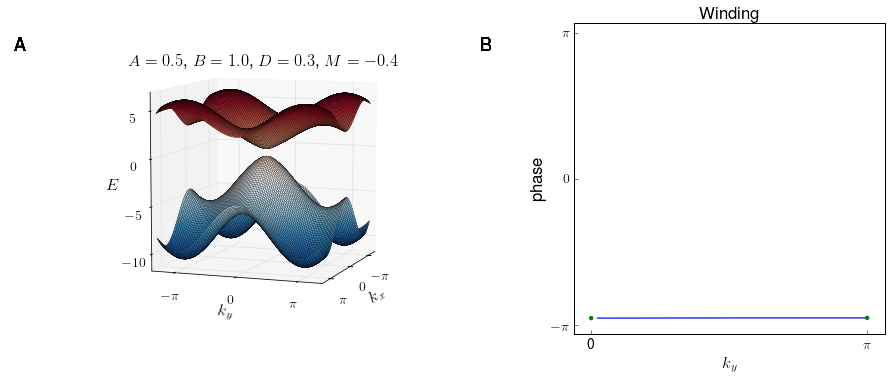
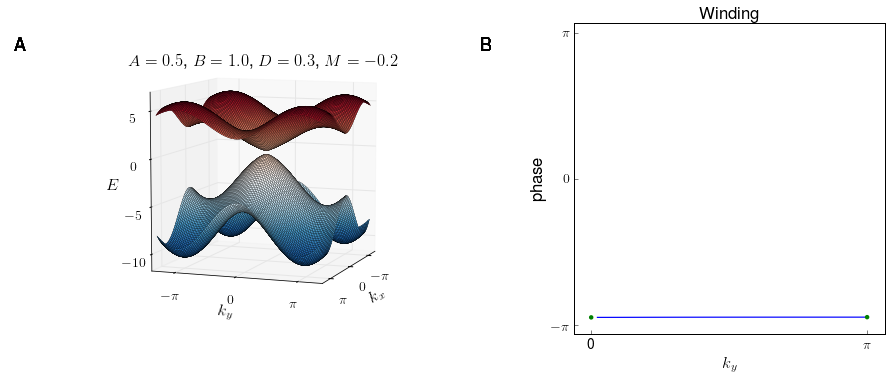
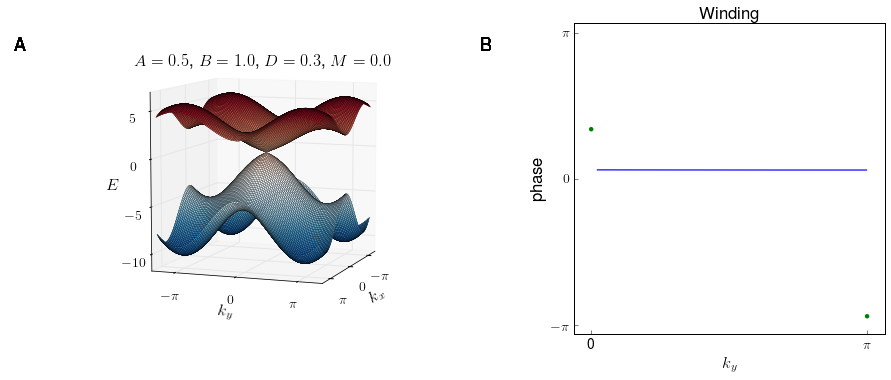
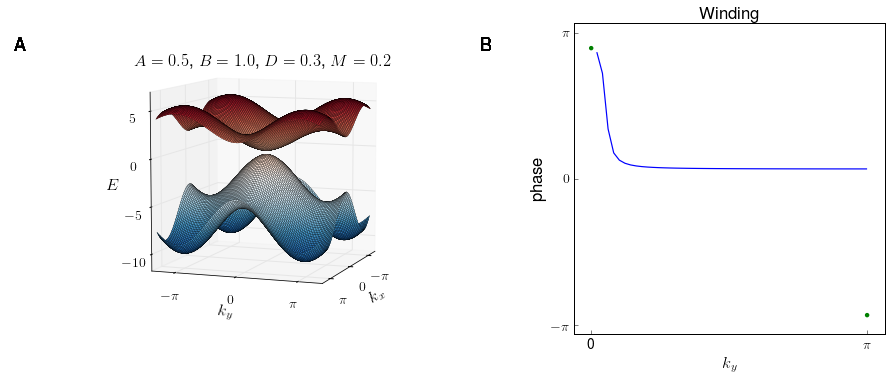
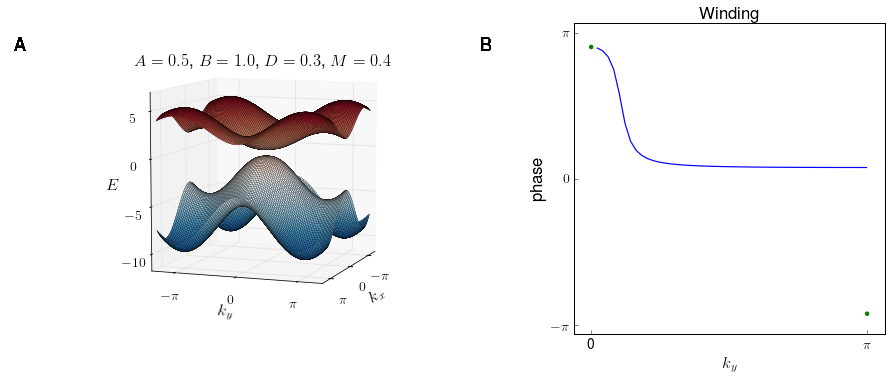
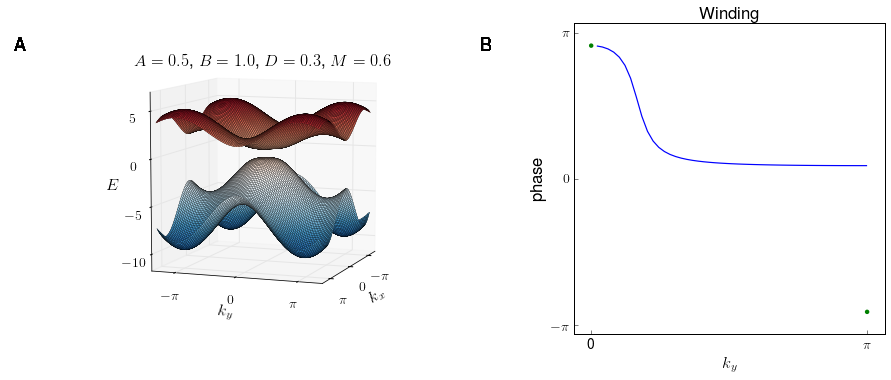
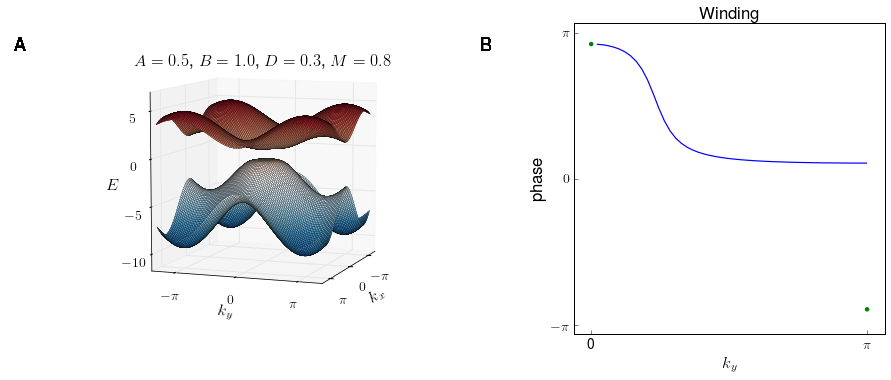
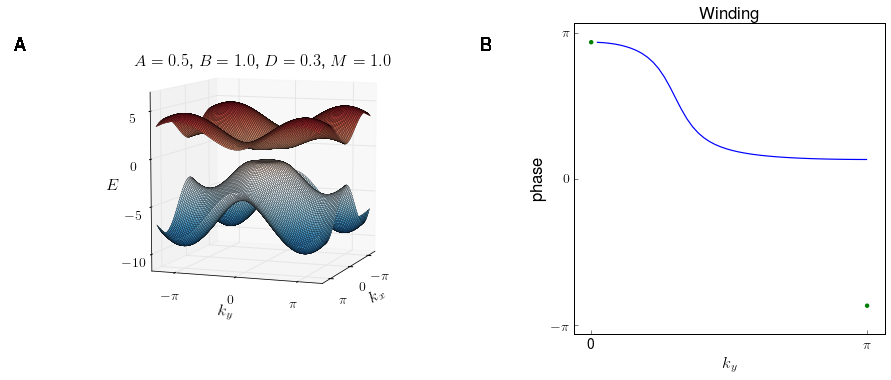

In [8]:
p = SimpleNamespace(a=1.0, Bz=0.0, ky=None, **bhz_parameters['topo2'])
sys = bhz(w=None)
scat_sys = make_scatter_sys()
k = (4 / 3) * np.linspace(-np.pi, np.pi, 101)
kwargs = {'k_x': k, 'k_y': k, 'title': title}
Ms = np.linspace(-1, 1, 11)
(holoviews.HoloMap({p.M: spectrum(sys, p, **kwargs) for p.M in Ms}, kdims=[r'$M$'])+
 holoviews.HoloMap({p.M: scattering_det_pfaff(scat_sys, p) for p.M in Ms}, kdims=[r'$M$']))

We now have a quantity equal to $\pm 1$, which cannot change continuously unless there's a gap closing (when there's a gap closing, $\det r$ becomes equal to $0$). It is relatively hard to prove that this invariant counts the pumping of fermion parity, but if you're interested, check out this paper:

In [9]:
PreprintReference('1107.2215', description="", show_abstract=False)

From reading the paper, or just from the above discussion, you see that it takes a lot of effort to derive an explicit expression for a topological invariant. Even though it is a hard task, sometimes one can guess the right result (one of us was indeed able to guess the above expression for $Q$ before it was known). Other times, one can invoke some simplification and obtain some important insight. This is what we will do in the next unit.

# A simplification: inversion symmetry

As just mentioned, topological invariants in higher dimensions are often difficult to write down and evaluate in the general case. Luckily, in the presence of [inversion symmetry](http://en.wikipedia.org/wiki/Parity_%28physics%29#Effect_of_spatial_inversion_on_some_variables_of_classical_physics) - which reverses the lattice coordinates with respect to a symmetry center - the topological condition can be stated in rather simple terms.
This turns out to be quite useful to describe most topological materials, which happen to have crystal structure with inversion symmetry. 

From our earlier discussion, we know that a system is a time-reversal invariant topological insulator if it has an odd number of helical edge states. We will now see how we can find an expression for the bulk topological invariant, using inversion symmetry and bulk-boundary correspondence.

So let's consider a two-dimensional Bloch Hamiltonian $H(\mathbf{k})$ with both inversion and time-reversal symmetry. Inversion symmetry has a unitary operator $\mathcal{P}$ which maps $\mathbf{k}\rightarrow -\mathbf{k}$ and satisfies $\mathcal{P}^2=1$. If we have both inversion symmetry $\mathcal{P}$ and time-reversal $\mathcal{T}$, we get an anti-unitary symmetry $\mathcal{T}\otimes\mathcal{P}$, which preserves $\mathbf{k}$ and squares to $-1$. 

> These are precisely the conditions needed for Kramers theorem to apply - only this time, every point $\mathbf{k}$ is mapped to itself because inversion symmetry is included as well. We conclude that every eigenstate at any $\mathbf{k}$ is two-fold degenerate.  We may label these two eigenstates with an index $\sigma=\pm$. If spin is a good quantum number, $\sigma$ labels two states with opposite spin. However, this may not be the case so we will just refer to it as a pseudospin associated with Kramers degeneracy.

Note that the simplification obtained by adding inversion symmetry is that the spectrum is two-fold degenerate at all $\mathbf{k}$ in the Brillouin zone. Time-reversal symmetry alone cannot guarantee that, because it maps $\mathbf{k}$ to $-\mathbf{k}$.

Our next step is to calculate the effective description of helical edge states at a domain wall between a topological phase and a non-topological phase. This is something we already know how to do thanks to our experience with domain walls in the Kitaev chain and in Chern insulators. It will give us insight into the topological transition and the bulk topological invariant.

## Study of a domain wall

Let's imagine that the helical edge runs along the $y$ direction, and that the domain wall is described by a mass profile $M(x)$ along the $x$ direction, which is zero at the domain wall:

![](figures/qsh_domain_wall.svg)
 
 
In this configuration, $k_y$ is still a good quantum number, and we can study the energy dispersion of states bound to the domain wall as a function of $k_y$. If the edge is gapless there must be a momentum, say $\bar{k}_y$, where counterpropagating modes cross at the Fermi level. Let's fix $k_y=\bar{k}_y$, and write down an effective Hamiltonian for the motion transverse to the domain wall.

We have in total four states, distinguished by two quantum numbers: their direction of propagation, which we denote with $b=\pm$, and their pseudospin $\sigma$. Inversion symmetry $\mathcal{P}$ flips the direction of propagation $b$, while the pseudo-spin degeneracy $\sigma$ is related to the combination of inversion and time-reversal $\mathcal{T}\otimes\mathcal{P}.$ To lowest order in the momentum $k_x$ perpendicular to the domain wall, the states at the transition point disperse linearly with $k_x$, and are two-fold degenerate. In fact, as we noted from Kramers degeneracy, the Hamiltonian must be chosen such that none of the terms break the two-fold degeneracy associated with the pseudospin $\sigma$. This means that the domain wall cannot couple states with different values of $\sigma$, which leads us to an effective Hamiltonian 

$$
H(\bar{k}_y)=\sum_{\sigma,b}\,k_x b\,|b,\sigma\rangle\langle b,\sigma|+M(x)(|+,\sigma\rangle\langle -,\sigma|+h.c.)]\,.
$$

where the factor $b$ is odd under time-reversal symmetry so that $k_x b$ is even under time-reversal symmetry.

We are back to an old friend, the one dimensional Dirac Hamiltonian with a position-dependent mass $M(x)$. Adapting our arguments from the first week, we can immediately say that the domain-wall hosts a pair of zero modes only if $M(x)$ changes sign.

As interesting as this sounds, we must remember that this pair of zero modes is present for $k_y=\bar{k}_y$. Because of inversion symmetry, there is necessarily an identical pair at $-\bar{k}_y$. So we get a total of 4 degenerate domain wall states from this type of gap closing - an even number of pairs. As we know form before, such pairs of gap closings do not affect the value of the topological invariant on the two sides of the domain walls. To change the value of the topological invariant, we would need an odd number of pairs crossing zero energy.

However, there are points in momentum space which are mapped onto each other by time-reversal symmetry, up to a reciprocal lattice vector. For these values, the above counting does not hold. People refer to these momenta as "time-reversal invariant momenta" or TRIMs. In the simple case of a square Brillouin zone, they are the points $(k_x, k_y) = (0,0), (0,\pi), (\pi,0),(\pi,\pi)$.

Since TRIMs are their own time-reversed partners, it is still possible for a gap closing at $\bar{k}_y=0$ or $\bar{k}_y=\pi$ to change the topology of the system. In this case, our doubling problem in momentum space is solved, and we can produce just one pair of edge modes at the domain wall. If we move the momentum $k_y$ slightly away from $\bar{k}_y$, the degenerate pair of modes splits linearly to form a single helical mode that produces a non-trivial fermion parity pump.

To make the distinction clear between a gap closing at a finite $\bar{k}_y$ and at a time-reversal invariant point, let's draw a sketch of the edge dispersion in the two cases.

![](figures/qsh_edge_dispersions.svg)

Kramers pairs are colored in red and blue and have the same linestyle. On the left, you have two pairs of Kramers partners, which however never meet at zero energy. On the right, there is a single Kramers pair meeting at zero energy. This argument summarizes the simplification that inversion symmetry brings to time-reversal invariant topological insulators.

> We can determine the topological invariant for the inversion symmetric topological insulators entirely from the bulk Hamiltonian at time-reversal invariant momenta, since gap closings at any other point can only add domain wall states in multiples of four.

Does this mean that any gap closing at a TRIM is a topological transition? The states $|b,\sigma\rangle$ are Bloch states with definite values of $k_y$. We are considering a time-reversal invariant value of $k_y$, and since $b$ is flipped by inversion symmetry, we can apply inversion symmetry to conclude that the states $|\pm,\sigma\rangle$ 
transform into each other under inversion i.e. $\mathcal{P}|\pm,\sigma\rangle= |\mp,\sigma\rangle$. By combining these states 
into symmetric and anti-symmetric superpositions

$$|e,\sigma\rangle=\frac{1}{\sqrt{2}}\left[|+,\sigma\rangle\, + \,|-,\sigma\rangle\right],\,\quad |o,\sigma\rangle=\frac{i}{\sqrt{2}}\left[|+,\sigma\rangle\, - \,|-,\sigma\rangle\right],$$

we obtain states that are even ($e$) and odd ($o$) under inversion—they are eigenstates of $\mathcal{P}$ with eigenvalue $+1$ or $-1$. They are also eigenstates of $M$ at $k_x=k_y=0$. The factor of $i$ in $|o,\sigma\rangle$ ensures a consistency under the time-reversal transformation, such that $\mathcal{T}|(e,o),\sigma\rangle=\sigma|(e,o),\sigma\rangle$.

Every gap closing at a TRIM is an even parity state crossing with an odd parity state. The effective Hamiltonian of such a gap closing must also add an extra Kramers pair of states at the domain wall, and therefore indeed every gap closing at a TRIM is a topological phase transition, while gap closings at all the other momenta are unimportant due to inversion symmetry.

This leads to a simplified way of computing a topological invariant of quantum spin Hall insulators with inversion symmetry:

> To compute a bulk topological invariant for a two-dimensional topological state with time reversal and inversion symmetry we need to keep track of the parity $P$ of all the occupied eigenstates of $H(\mathbf{k})$ at the different time-reversal invariant momenta in the Brillouin zone. We may write such a bulk topological invariant as a product

> $$Q=\prod_{n,j}P_{n,j}\,,$$

> where $P_{n,j}$ is the parity, $n$ runs over the occupied bands of $H(\mathbf{k})$ and $j$ over the time-reversal invariant momenta.

You might now worry whether this definition of the invariant relied on having a smooth domain wall. From the fermion parity pump argument, bulk-edge correspondence implies that the bulk must be topologically non-trivial once you have edge states for any termination. Reversing this argument, we know that once we have a topologically non-trivial bulk, we must have helical edge states for any termination.

Thus, by looking at smooth domain walls we are able to establish a connection between the topological invariant in the presence of time-reversal and inversion symmetry, and the existence of helical edge states and fermion-parity pumping that characterizes the two dimensional topological insulator.

As a bonus, thanks to the previous arguments we can begin to understand how to look for two-dimensional topological insulators among real materials, or how to create them. The main idea is to generate a "band-inversion" between an even and an odd parity band at a TRIM.

Such a band inversion is not impossible to achieve in real materials, and can be captured using the BHZ model. But let's leave this to the next lecture.

In [10]:
question = ("What is the value of the parity invariant $Q$ if you stack together two quantum spin Hall systems  "
            "in the topological phase (i.e., both with $Q=-1$)?")

answers = ["The system has edge states and is therefore topologically non-trivial.",
           "The total number of odd parity occupied orbitals must be even, so you get $Q=1$.",
           "It depends on whether the helical states in the two layers have same "
           "or opposite spin for a given direction.",
           "The invariant depends on the number of edge Dirac points at $k$ away from 0."]

explanation = ("Both layers have $Q=-1$ and hence an odd number of odd parity orbitals. Therefore, by combining the layers  "
               "we get an even number of odd parity orbitals. Hence $Q$, which is the parity of odd parity orbitals must be "
               "$Q=1$.")

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=1, explanation=explanation)

MoocMultipleChoiceAssessment(**{'correct_answer': 1, 'explanation': 'Both layers have $Q=-1$ and hence an odd number of odd parity orbitals. Therefore, by combining the layers  we get an even number of odd parity orbitals. Hence $Q$, which is the parity of odd parity orbitals must be $Q=1$.', 'max_attempts': 2, 'question': 'What is the value of the parity invariant $Q$ if you stack together two quantum spin Hall systems  in the topological phase (i.e., both with $Q=-1$)?', 'answers': ['The system has edge states and is therefore topologically non-trivial.', 'The total number of odd parity occupied orbitals must be even, so you get $Q=1$.', 'It depends on whether the helical states in the two layers have same or opposite spin for a given direction.', 'The invariant depends on the number of edge Dirac points at $k$ away from 0.'], 'display_name': 'Question'})

# Summary

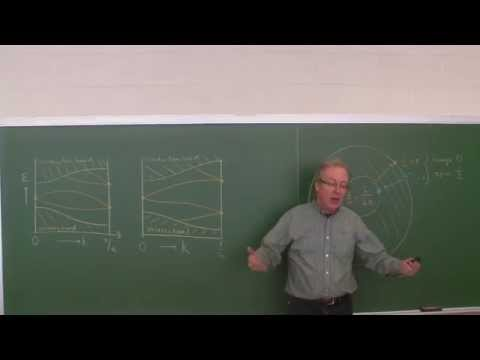

In [11]:
MoocVideo("ft9ppqqLhH4", src_location='5.1-summary', res='360')

**Questions about what you just learned? Ask them below!**

In [12]:
MoocDiscussion("Questions", "QSHE - theory")

MoocDiscussion(**{'discussion_id': '54c9bf36251dec07fb2685178cfe47ea', 'discussion_target': 'QSHE - theory', 'discussion_category': 'Questions', 'display_name': 'QSHE - theory'})